# Student_Att:

Date:23/01/23

This file contains functions related to the handling of data to produce the attendance record from a Student ID, specifically a table and appropriate bar graphs. 


## Imports 


In [3]:

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolours
import sqlite3
from pathlib import Path
import os
import glob
import matplotlib.pyplot as plt
from ipynb.fs.defs.CW_Preprocessing import *
from pandas.api.types import CategoricalDtype



## Functions 

### Verification Lists

In [4]:
def get_sid_list():
    """
    Creates a dataframe only containing SIDs.
    """
    student_att = get_complete_attendence()
    student_att = student_att['sid']
    sid_list = student_att.tolist()
    return sid_list

def get_semester_list():
    """
    Creates a dataframe only containing semesters.
    """
    module_att = get_complete_session()
    module_att = module_att['semester']
    semester_list = module_att.tolist()
    return semester_list


### Table and Graph producing functions

In [5]:
class StudentAtt:
    
    complete_session_df = get_complete_session() 

    def merge_stuatt_compsess(sid, semester):
        """
        Extracts dataframe from database of a specific student. Then merges this dataframe with the complete_sessions dataframe.
        Final dataframe is attendence of a single sudent with all the session details.
        """
        student_att = sid_attendence(sid)
        complete_session_df = get_complete_session()
        student_att = student_att.transpose()
        student_att = student_att.reset_index()
        student_att = pd.DataFrame(student_att)
        student_att = student_att[1:]
        student_att = student_att.rename(columns={'index': 'session_id', 0 :'att'})
        merged_df = complete_session_df.merge(student_att, on = "session_id", how = 'inner')
        merged_df = merged_df[merged_df['semester'] == semester]
        return(merged_df)
    
    def student_att_week_table(merged_df):
        """
        Formats and filters merge_stuatt_compsess dataframe. This creates a clean, table that shows the average weekly
        attendance from a single Student ID.
        """
        filter_merged_df = merged_df[['week', 'module', 'att']]
        pivot_merged_df = filter_merged_df.pivot_table(index = ['week','module'], aggfunc ='size')
        filter_merged_df = filter_merged_df.join(pivot_merged_df.to_frame(), on = ['week','module'], how = 'outer')
        filter_merged_df = filter_merged_df.rename(columns={0 :'s_count'})
        filter_merged_df['pct'] = (filter_merged_df['att'] / filter_merged_df["s_count"] * 100)
        filter_merged_df['pct'] = filter_merged_df['pct'].replace(np.nan, 0)
        clean_merged_week = filter_merged_df.reset_index().pivot_table(values="pct", index="week", columns="module", aggfunc='sum')
        clean_merged_week = clean_merged_week.replace(0, None)
        clean_merged_week = clean_merged_week.dropna(axis=1, how='all')
        return(clean_merged_week)
    
    def student_att_type_table(merged_df):
        """
        Formats and filters merge_stuatt_compsess dataframe. This creates a clean, table that shows the average
        attendance from a single Student ID based on the type of session (e.g Lecture, Test).
        """
        filter_merged_df = merged_df[['type', 'module', 'att']]
        pivot_merged_df = filter_merged_df.pivot_table(index = ['type','module'], aggfunc ='size')
        filter_merged_df = filter_merged_df.join(pivot_merged_df.to_frame(), on = ['type','module'], how = 'outer')
        filter_merged_df = filter_merged_df.rename(columns={0 :'s_count'})
        filter_merged_df['pct'] = (filter_merged_df['att'] / filter_merged_df["s_count"] * 100)
        filter_merged_df['pct'] = filter_merged_df['pct'].replace(np.nan, 0)
        clean_merged_type = filter_merged_df.reset_index().pivot_table(values="pct", index="type", columns="module", aggfunc='sum')
        clean_merged_type = clean_merged_type.replace(0, None)
        clean_merged_type = clean_merged_type.dropna(axis=1, how='all')
        return(clean_merged_type)
    
    def student_att_time_table(merged_df):
        """
        Formats and filters merge_stuatt_compsess dataframe. This creates a clean, table that shows the average
        attendance from a single Student ID based on the start time of a session.
        """
        merged_df['start_time']= pd.to_datetime(merged_df['start_time'])
        merged_df['start_time'] = merged_df['start_time'].dt.strftime('%H:%M')
        filter_merged_df = merged_df[['start_time', 'att']]
        pivot_merged_df = filter_merged_df.pivot_table(index = ['start_time'], aggfunc ='size')
        filter_merged_df = filter_merged_df.join(pivot_merged_df.to_frame(), on = ['start_time'], how = 'outer')
        filter_merged_df = filter_merged_df.rename(columns={0 :'s_count'})
        filter_merged_df['pct'] = (filter_merged_df['att'] / filter_merged_df["s_count"] * 100)
        filter_merged_df['pct'] = filter_merged_df['pct'].replace(np.nan, 0)
        clean_merged_time = filter_merged_df.reset_index().pivot_table(values="pct", index="start_time", aggfunc='sum')
        return(clean_merged_time)
    
    def student_att_day_table(merged_df):
        """
        Formats and filters merge_stuatt_compsess dataframe. This creates a clean, table that shows the average
        attendance from a single Student ID based on the day of the week.
        """
        filter_merged_df = merged_df[['day_of_week', 'att']]
        pivot_merged_df = filter_merged_df.pivot_table(index = ['day_of_week'], aggfunc ='size')
        filter_merged_df = filter_merged_df.join(pivot_merged_df.to_frame(), on = ['day_of_week'], how = 'outer')
        filter_merged_df = filter_merged_df.rename(columns={0 :'s_count'})
        filter_merged_df['pct'] = (filter_merged_df['att'] / filter_merged_df["s_count"] * 100)
        filter_merged_df['pct'] = filter_merged_df['pct'].replace(np.nan, 0)
        cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
        cat_type = CategoricalDtype(categories=cats, ordered=True)
        filter_merged_df['day_of_week'] = filter_merged_df['day_of_week'].astype(cat_type)
        clean_merged_day = filter_merged_df.reset_index().pivot_table(values="pct", index="day_of_week", aggfunc='sum')
        return(clean_merged_day)

    def sid_table(sid, semester, variable = "week"):
        """
        Decides which dataframe filter to apply to merge_stuatt_compsess dataframe based on the variable input. 
        It then applies the filter and convert the pandas dataframe into a matplotlib table which is then plotted as a figure.
        """
        sid_table_df = StudentAtt.merge_stuatt_compsess(sid, semester)
        variable = str(variable)
        if variable == "week":
            sid_table_df = StudentAtt.student_att_week_table(sid_table_df)
        elif variable == "type":
            sid_table_df = StudentAtt.student_att_type_table(sid_table_df)
        elif variable == "time":
            sid_table_df = StudentAtt.student_att_time_table(sid_table_df)
        elif variable == "day":
            sid_table_df = StudentAtt.student_att_day_table(sid_table_df)
        else:
            sid_table_df = StudentAtt.student_att_week_table(sid_table_df)
        sid_table_df = sid_table_df.reset_index()
        sid_table_df = sid_table_df.rename(columns={'week': 'Week'})
        sid_table_df = sid_table_df.fillna(value=np.nan)
        sid_table_df = sid_table_df.round(1)
        sid_table_fig, sid_table_ax = plt.subplots(figsize=(10, 2))
        sid_table_fig.patch.set_visible(False)
        sid_table_ax.axis('off')
        sid_table_ax.axis('tight')
        table = sid_table_ax.table(cellText=sid_table_df.values, colLabels=sid_table_df.columns, loc='best', 
                         colLoc='center')
        table.scale(1,3)
        sid_table_ax.set_title('Attendance record % for sid: {} in semester {}:'.format(sid, semester), loc = 'left',)
        
    def plot_sid_graph(sid, semester, variable ="week"):
        """
        Decides which dataframe filter to apply to merge_stuatt_compsess dataframe based on the variable input. 
        It then applies the filter and then plots the datframe into a bar chart.
        """
        df = StudentAtt.merge_stuatt_compsess(sid, semester)
        variable = str(variable)
        if variable == "week":
            c_df = StudentAtt.student_att_week_table(df)
            c_df.plot(kind='bar', ylabel='Attendence %', xlabel = 'Week', rot = 0)
        elif variable == "day":
            c_df = StudentAtt.student_att_day_table(df)
            c_df.plot(kind='bar', ylabel='Attendence %', xlabel = 'Day of Week',rot = 45)
        elif variable == "time":
            c_df = StudentAtt.student_att_time_table(df)
            c_df.plot(kind='bar', ylabel='Attendence %', xlabel = 'Start Time')
        elif variable == "type":
            c_df = StudentAtt.student_att_type_table(df)
            c_df.plot(kind='bar', ylabel='Attendence %', xlabel = 'Type')
        else:
            c_df = StudentAtt.student_att_week_table(df)
            c_df.plot(kind='bar', ylabel='Attendence %', xlabel = 'Week', rot = 0)


## Testing 

In [6]:
def studentatt_testing_dataframe():
    """
    Testing StudentAtt intial dataframe function 'merge_stuatt_compsess' that's used throughout the class.
    """
    merge_s_c = StudentAtt.merge_stuatt_compsess(0, 1) # sid = 0, semester = 1
    display(merge_s_c)
    
    
studentatt_testing_dataframe()

,session_id,date,start_time,end_time,day_of_week,type,room,semester,week,module,att
0,S1_W1_1_22COA133,2022-10-03 00:00:00,14:00:00.000000,16:00:00.000000,Monday,Lecture,CC012,1,1,22COA133,1.0
1,S1_W1_2_22COA133,2022-10-06 00:00:00,09:00:00.000000,11:00:00.000000,Thursday,Computer Lab,N001...,1,1,22COA133,1.0
2,S1_W1_3_22COA133,2022-10-06 00:00:00,11:00:00.000000,13:00:00.000000,Thursday,Computer Lab,N001...,1,1,22COA133,None
3,S1_W2_1_22COA133,2022-10-10 00:00:00,14:00:00.000000,16:00:00.000000,Monday,Lecture,CC012,1,2,22COA133,1.0
4,S1_W2_2_22COA133,2022-10-13 00:00:00,09:00:00.000000,11:00:00.000000,Thursday,Computer Lab,N001...,1,2,22COA133,0.0
5,S1_W2_3_22COA133,2022-10-13 00:00:00,11:00:00.000000,13:00:00.000000,Thursday,Computer Lab,N001...,1,2,22COA133,None
6,S1_W3_1_22COA133,2022-10-17 00:00:00,14:00:00.000000,16:00:00.000000,Monday,Lecture,CC012,1,3,22COA133,0.0
7,S1_W3_2_22COA133,2022-10-20 00:00:00,09:00:00.000000,11:00:00.000000,Thursday,Computer Lab,N001...,1,3,22COA133,0.0
8,S1_W3_3_22COA133,2022-10-20 00:00:00,11:00:00.000000,13:00:00.000000,Thursday,Computer Lab,N001...,1,3,22COA133,None
9,S1_W4_1_22COA133,2022-10-24 00:00:00,14:00:00.000000,16:00:00.000000,Monday,Lecture,CC012,1,4,22COA133,1.0


None

None

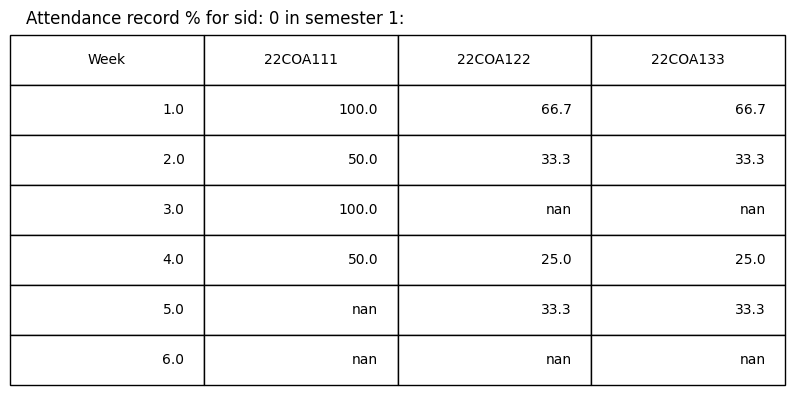

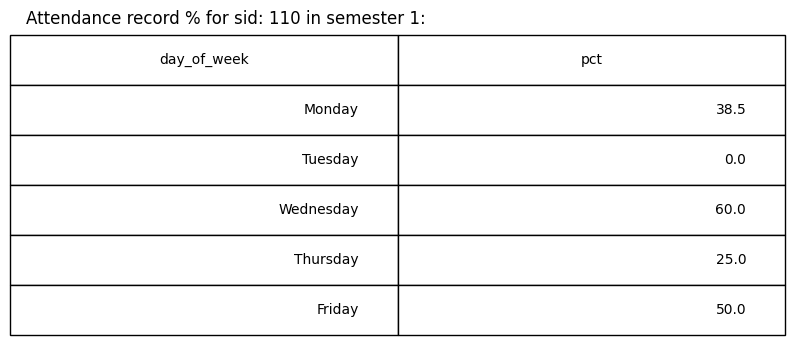

In [7]:
def studentatt_testing_tables():
    """
    Testing StudentAtt table plotting functions.
    """
    week_table_test = StudentAtt.sid_table(0, 1, "week") # sid = 0, semester = 1
    day_table_test = StudentAtt.sid_table(110, 1, "day") # sid = 110, semester = 1
    display(week_table_test)
    display(day_table_test)

    
studentatt_testing_tables()

None

None

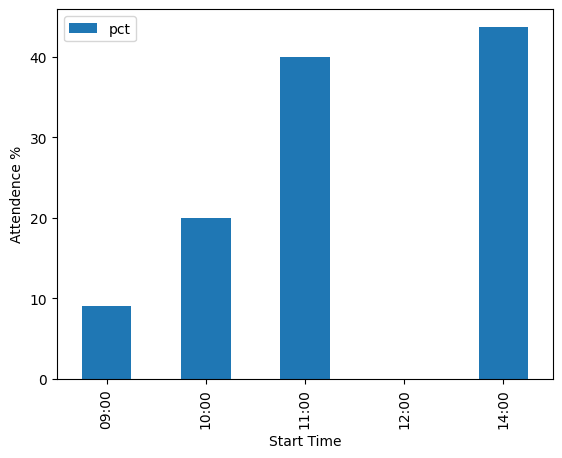

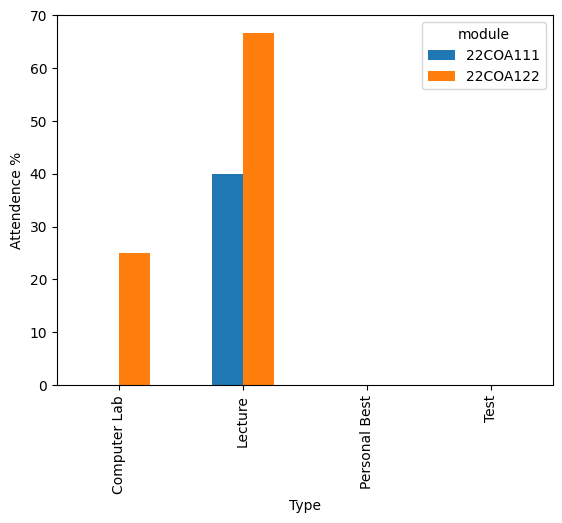

In [8]:
def studentatt_testing_graphs():
    """
    Testing StudentAtt graph plotting functions.
    """
    time_graph_test = StudentAtt.plot_sid_graph(40, 1, "time") # sid = 40, semester = 1
    type_graph_test = StudentAtt.plot_sid_graph(34, 1, "type") # sid = 34, semester = 1
    display(time_graph_test)
    display(type_graph_test)
    
    
studentatt_testing_graphs()